In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import yaml
from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from functions import load_data, plot_from_batch_generator
from netrunner import CNNetRunner

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
config = yaml.safe_load(open('config.yaml'))

In [3]:
transformer = transforms.Compose([
    transforms.Resize((config['SIZE_H'], config['SIZE_W'])),        
    transforms.ToTensor(),                      
    transforms.Normalize(config['image_mean'], config['image_std'])
])

In [4]:
train_batch, val_batch = load_data(config['DATA_PATH'], transformer)

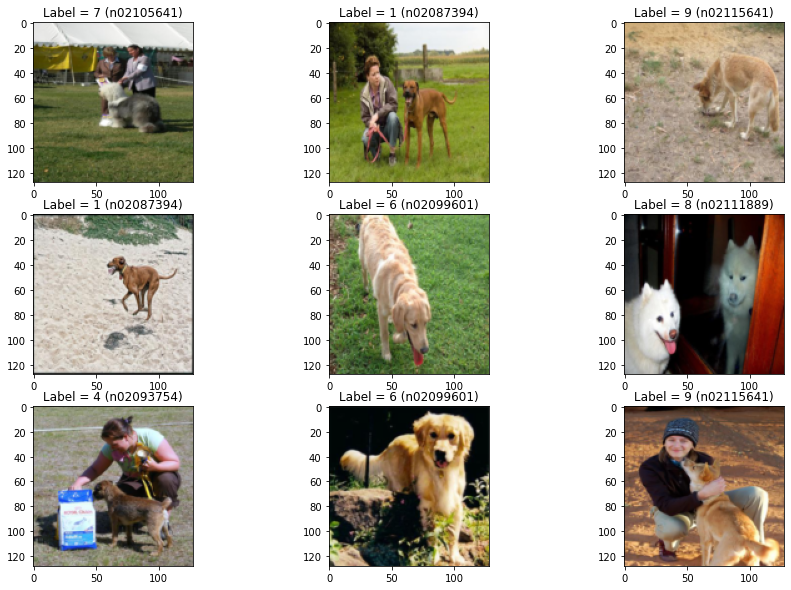

In [11]:
plot_from_batch_generator(train_batch)

## Create model

In [5]:
def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            conv_block_3x3(3, 32),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(32, 64),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(64, 64),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(64, 128),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(128, 128),
            nn.AdaptiveMaxPool2d(1),
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, config['EMBEDDING_SIZE']),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(config['EMBEDDING_SIZE'], config['NUM_CLASSES'], bias=False)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [11]:
model_cnn = MyModel()
summary(model_cnn, (3, config['SIZE_H'], config['SIZE_W']), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

In [12]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
ckpt_name='model_cnn_2.ckpt'
cnn = CNNetRunner(model_cnn, device, opt, checkpoint_name=ckpt_name)

val: loss: 1.7229 | accuracy: 0.4935 | f1_score: 0.4718


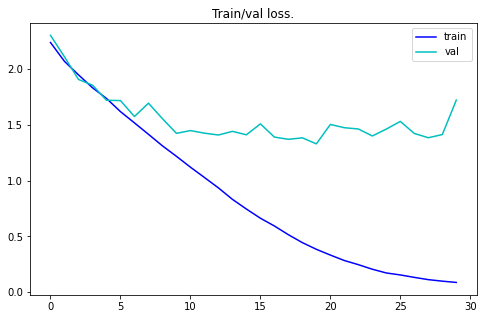

In [13]:
# image 128x128, batch_size 512
cnn.train(train_batch, val_batch, n_epochs=config['EPOCH_NUM'], visualize=True, average='macro')